# Processing of the "Construction of residentials" dataset

## Importing libraries and dataset

In [2]:
import pandas as pd
import re
from matplotlib import pyplot as plt 
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
# pip install "folium>=0.12" matplotlib mapclassify
# pip install xlrd

# pip install keplergl


In [8]:
df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_resid_geocoded.csv",sep=",",on_bad_lines="warn")


/tmp/ipykernel_302370/3905520969.py:1: DtypeWarning: Columns (1,3,5,7,8,12,17,19,21,22,23,25,31,33,35,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,109,115,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("https://minio.lab.sspcloud.fr/mligeret1/constructions_resid_geocoded.csv",sep=",",on_bad_lines="warn")


In [9]:
df.head()
df = df.iloc[1:]
df.head()



Unnamed: 0 Code de la région du lieu des travaux - Code de la zone  \
1           1                                                 82        
2           2                                                 82        
3           3                                                 82        
4           4                                                 82        
5           5                                                 82        

  Code de la région du lieu des travaux - Libellé de la zone  \
1                                        Rhône-Alpes           
2                                        Rhône-Alpes           
3                                        Rhône-Alpes           
4                                        Rhône-Alpes           
5                                        Rhône-Alpes           

  Code du département du lieu des travaux - Code de la zone  \
1                                                 01          
2                                                 01          
3                                                 01          
4                                                 01          
5                                                 01          

  Code du département du lieu des travaux - Libellé de la zone  \
1                                                Ain             
2                                                Ain             
3                                                Ain             
4                                                Ain             
5                                                Ain             

  Code de la commune du lieu des travaux  \
1                                  01001   
2                                  01001   
3                                  01001   
4                                  01001   
5                                  01001   

  Type de DAU -- demande d’autorisation d’urbanisme (PC ou DP généralement, rarement PA)  \
1                                                 PC                                       
2                                                 PC                                       
3                                                 PC                                       
4                                                 PC                                       
5                                                 PC                                       

  Numéro d’enregistrement de la DAU Etat d’avancement du projet  \
1                     00100113V0003                           5   
2                     00100113V0004                           6   
3                     00100113V0006                           6   
4                     00100113V0007                           6   
5                     00100113V0008                           6   

  Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  ...  \
1                                         2013-09-20                  ...   
2                                         2013-09-30                  ...   
3                                         2013-09-20                  ...   
4                                         2013-11-16                  ...   
5                                         2013-12-06                  ...   

                  result_name               result_street result_postcode  \
1           Rue de Munetville           Rue de Munetville          1400.0   
2  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
3  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
4  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   
5  Lotissement le Panoramique  Lotissement le Panoramique          1400.0   

               result_city                 result_context result_citycode  \
1  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   
2  L'Abergement-Clémenciat  01, Ain, Auvergne-Rhône-Alpes           01001   
3  L'Abergement-Clémencia

## TODO : Checking for errors in the geocoding
We first check if there are still some lines that were not geocoded during the batch coding (due to time-out). We send individual request to the API. 

In [5]:
df[df["result_status"] == "error"].loc[:,"Adresse_complete"]


23595                           GRAND ETANG DE SERVAS SERVAS
23597        350 RUE DES AULNES GRAND ETANG DE SERVAS SERVAS
23599                                     MONTMAIN SERVIGNAT
23600                               MONTMAIN LOT A SERVIGNAT
23601                                 RUE DU BOURG SERVIGNAT
                                 ...                        
1665230    RUE DU PETIT BOIS LOTISSEMENT SCI ESPOIR LOT N...
1665231    20 RUE FIRMIN PETIT 20 BIS ( DIVISION DE PARCE...
1665234         69 ROUTE DE LA TORCHAISE VOUNEUIL-SOUS-BIARD
1665235       29 CHEMI DU PETIT BEAUVOIR VOUNEUIL-SOUS-BIARD
1726695                 80 BOULE ROGER SALENGRO NOISY LE SEC
Name: Adresse_complete, Length: 85, dtype: object

## Grouping columns together
To do so, we target columns with the same name

In [6]:
for c in df.columns:
    print(c)

Unnamed: 0
Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Type de DAU -- demande d’autorisation d’urbanisme (PC ou DP généralement, rarement PA)
Numéro d’enregistrement de la DAU
Etat d’avancement du projet
Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale
Date réelle d’ouverture de chantier
Date réelle d’achèvement des travaux
Année de dépôt de la DAU
Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)
Date (mois) de prise en compte (DPC) de l’autorisation initiale
Date (mois) de prise en compte (DPC) de l’ouverture du chantier
Date (mois) (DPC) de dernière mise à jour des données
Catégorie du demandeur (maître d’ouvrage) selon Sitadel
Code d’activité principale de l’établissement d’un

In [26]:
col_metadata = [x for x in df.columns if "DAU" in x] + ["Unnamed: 0"]
col_meta_location = [x for x in df.columns if "lieu des travaux" in x]
col_dates_travaux = [x for x in df.columns if "Date" in x]
col_demandeurs = [x for x in df.columns if "demandeur" in x ]
col_precise_location = [x for x in df.columns if "du terrain" in x and ("Superficie du terrain" not in x)] 
col_cadastres = [x for x in df.columns if "cadastr" in x]
col_construction_details = [x for x in df.columns if "Présence" in x or "Indicateur" in x] #dans le projet 
col_number_created_housings_details = [x for x in df.columns if "logements" in x and "créés" in x and "Nombre total de logements créés" not in x]
col_details_transf = [x for x in df.columns if "Surface" in x]
col_from_geocodage = [i for i in df.columns if "result_" in i]

col_irrelevant = col_metadata + col_dates_travaux + col_precise_location + col_cadastres + col_construction_details + col_number_created_housings_details + col_details_transf + col_from_geocodage
col_relevant =  [c for c in df.columns if c not in col_irrelevant] 
for c in col_relevant:
    print(c)

Code de la région du lieu des travaux - Code de la zone
Code de la région du lieu des travaux - Libellé de la zone
Code du département du lieu des travaux - Code de la zone
Code du département du lieu des travaux - Libellé de la zone
Code de la commune du lieu des travaux
Etat d’avancement du projet
Catégorie du demandeur (maître d’ouvrage) selon Sitadel
Code d’activité principale de l’établissement d’un demandeur avéré en tant que personne morale
Catégorie juridique d’un demandeur avéré en tant que personne morale
Dénomination d’un demandeur avéré en tant que personne morale
Numéro SIREN d’un demandeur avéré en tant que personne morale
Numéro SIRET d’un demandeur avéré en tant que personne morale
Code postal du demandeur
Localité du demandeur
Superficie du terrain
Code zone opératoire
Nature du projet déclarée par le demandeur
Nature de projet détaillée
Destination principale
Type principal de transformation
Type principal des locaux d’origine transformés
Nombre de niveaux du bâtiment

In [27]:
df.loc[:,col_relevant].sample(50)



Code de la région du lieu des travaux - Code de la zone  \
520971                                                  73        
1669565                                                 74        
897643                                                  24        
959183                                                  25        
444179                                                  94        
1335890                                                 43        
1216216                                                 72        
357238                                                  82        
991310                                                  52        
1381126                                                 82        
935984                                                  52        
1326370                                                 82        
1811678                                                  4        
415612                                                  53        
107486                                                  91        
1281317                                                 42        
786790                                                  72        
1589373                                                 93        
189411                                                  25        
713057                                                  82        
1353658                                                 52        
1186368                                                 83        
484779                                                  73        
1649233                                                 52        
287905                                                  53        
1394230                                                 82        
1440747                                                 23        
1823381                                                  4        
1129695                                                 22        
1806682                                                  4        
801750                                                  82        
1291053                                                 42        
1437855                                                 23        
809260                                                  82        
1836930                                                  6        
813016                                                  82        
1819583                                                  4        
33169                                                   22        
1553278                                                 93        
906945                                                  24        
944190                                                  52        
1078407                                                 41        
305643                                                  72        
1294402                                                 42        
1335758                                                 43        
1235681                                                 91        
1576583                                                 93        
1601259                                                 93        
350663                                                  82        
1823892                                                  4        

        Code de la région du lieu des travaux - Libellé de la zone  \
520971                                       Midi-Pyrénées           
1669565                                           Limousin           
897643                                              Centre           
959183                                     Basse-Normandie           
444179                                               Corse           
1335890                                      Franche-Comté           
1216216                                          Aquitaine           
357238                        

<Axes: >

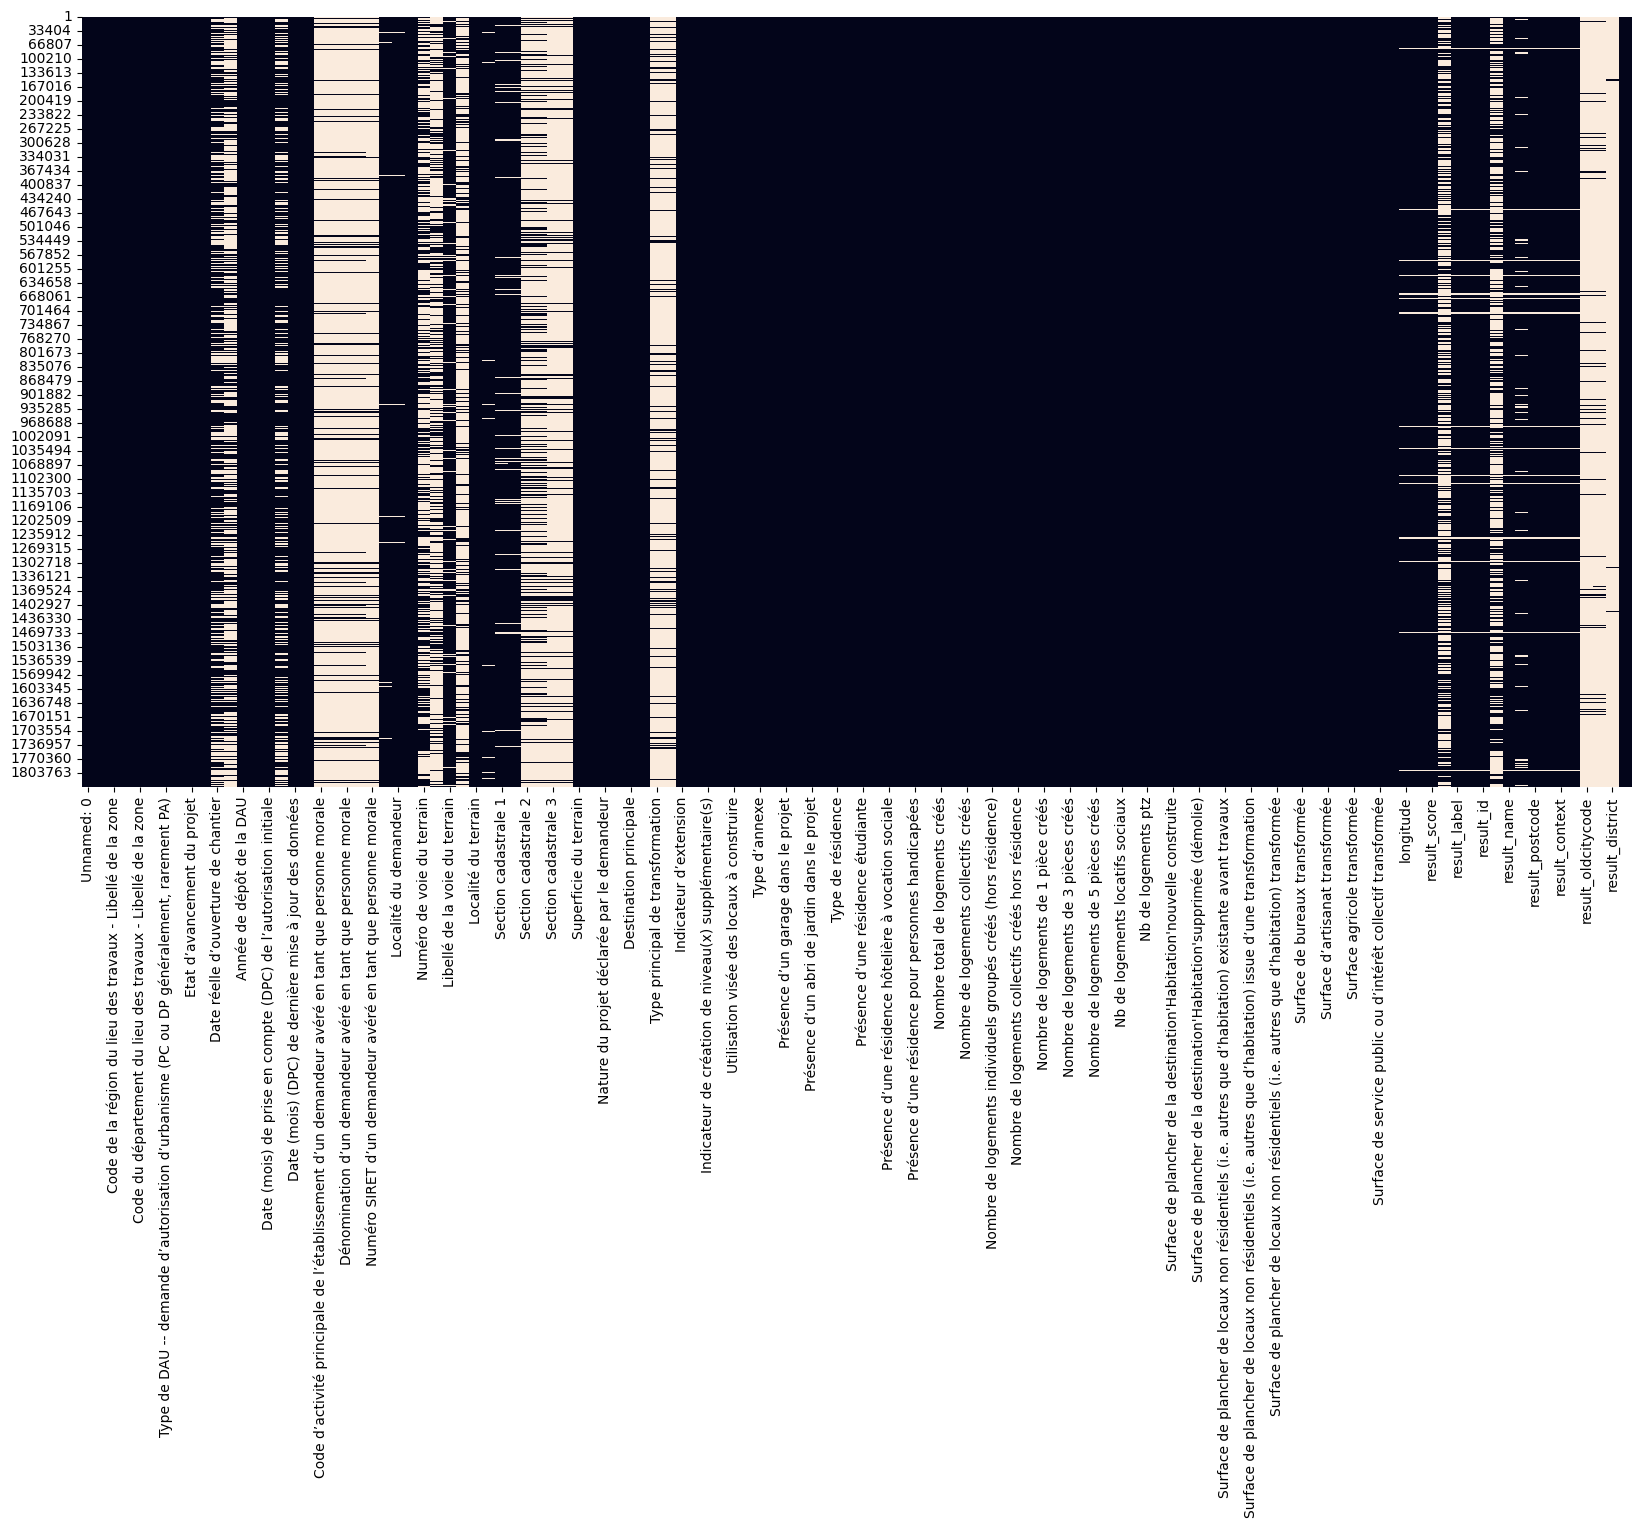

In [16]:
plt.figure(figsize=(20,10))

sns.heatmap(df.isna(), cbar=False)


In [30]:
df["Nombre total de logements créés"].sample(50)

1679952    1
1192027    1
1425015    1
1474289    3
982946     1
1126456    1
260284     1
233340     1
1130824    1
295544     1
1129967    1
1028423    1
52392      1
262293     3
1057636    1
491398     2
1825516    1
517678     1
260106     1
471886     1
1065696    1
151428     1
1014524    1
815365     1
1534621    1
634511     1
1366156    3
1196453    1
318865     1
563453     1
418914     1
734237     1
507389     1
352182     1
22853      1
1801046    1
703643     1
302973     1
536315     2
1469505    1
402273     1
1663306    1
73812      1
948977     1
465339     1
938023     5
1139481    1
866075     1
1804826    1
1091088    1
Name: Nombre total de logements créés, dtype: object

#### **REACTIVER A LA FIN, DESACTIVER TEMPORAIREMENT**

def identification_usage(ligne):
    col_max = ligne.iloc[len(dates_lieux_travaux):].idxmax()
    pattern = r"Surface de plancher de la destination (.+?) (nouvelle construite|issue d'une transformation)$"

    match = re.search(pattern, col_max, re.IGNORECASE)
    print("Testing column:", repr(col_max))
    return match.group(1) if match else None

df_usage = df.loc[:,colonnes_pertinentes].sample(1000)
df_usage["Destination du lieu"]= df_usage.apply(identification_usage, axis = 1)



## Arranging columns types 


In [31]:
dico_variables = pd.read_excel("https://data.statistiques.developpement-durable.gouv.fr/dido/api/files/ab799b04-0b03-4f96-949c-eb23c478a8e8")

In [42]:
dico_variables.head(5).style


### Retrouver depuis le dictionnaire 

In [45]:
def variable_types(ligne):
    if ("Année" in ligne["Description de la variable"]):
        return None
    if "Alphanumérique" in ligne["Format"]:
        return "string"
    if "Numérique" in ligne["Format"]:
        return "float64"
        
dico_variables["Format_python"] = dico_variables.apply(variable_types, axis=1)


In [46]:
dtype_map

{'Code de la commune du lieu des travaux': 'string',
 'Année de dépôt de la DAU': None,
 'Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)': None,
 'Date (mois) (DPC) de dernière mise à jour des données': None,
 'Code postal du demandeur': 'string',
 'Localité du demandeur': 'string',
 'Indicateur de recours à un architecte': 'string',
 'Numéro de voie du terrain': 'string',
 'Type de voie du terrain': 'string',
 'Libellé de la voie du terrain': 'string',
 'Lieu-dit du terrain': 'string',
 'Localité du terrain': 'string',
 'Code postal du terrain': 'string',
 'Section cadastrale 1': 'string',
 'Numéro parcelle cadastrale 1': 'string',
 'Section cadastrale 2': 'string',
 'Numéro parcelle cadastrale 2': 'string',
 'Section cadastrale 3': 'string',
 'Numéro parcelle cadastrale 3': 'string',
 'Superficie du terrain': 'Int64',
 'Nature du projet déclarée par le demandeur': 'string',
 'Nature de projet détaillée': 'string',
 'D

In [48]:
dtype_map = dict(zip(dico_variables["Description de la variable"], dico_variables["Format_python"]))
dtype_map = {col : python_type for col, python_type in dtype_map.items() if col in df.columns}
df = df.astype(dtype_map, errors="ignore")


In [49]:
df.dtypes.to_frame().style

### Régler la question de la date 

In [50]:
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].value_counts().to_frame().style #to verify that dates are well specified under the format %Y%m, i.e. year with 4 digits followed by month
df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"] = pd.to_datetime(df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"], format="%Y-%m", errors="coerce")


We repeat the operation for the other columns that involve date/year dtypes


In [52]:
for col_date in col_dates_travaux:
    print(df[col_date].value_counts().to_frame()) #to verify the format of the date

                                                    count
Date réelle d’autorisation (PC) ou de non-oppos...       
2013-02-21                                           1608
2013-02-28                                           1342
2022-02-10                                           1260
2013-02-20                                           1221
2013-02-14                                           1210
...                                                   ...
2020-05-01                                              2
2025-11-10                                              2
2025-09-14                                              2
2025-11-01                                              2
2025-11-13                                              1

[4695 rows x 1 columns]
                                     count
Date réelle d’ouverture de chantier       
2014-09-01                            1452
2021-09-01                            1435
2021-03-01                            1352
2018-1

In [53]:
col_date_format_ymd = [col_dates_travaux[i] for i in [0,1,2,3]]
col_date_format_ym = [col_dates_travaux[i] for i in [4,5,6]]

In [54]:
for col in col_date_format_ymd:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m-%d")



1          2013-09-20
2          2013-09-30
3          2013-09-20
4          2013-11-16
5          2013-12-06
              ...    
1837133    2025-07-03
1837134    2013-08-27
1837135    2020-09-11
1837136    2021-06-20
1837137    2022-04-30
Name: Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale, Length: 1837137, dtype: object
1          2013-11-26
2          2013-12-06
3          2013-11-26
4          2014-01-24
5          2014-03-12
              ...    
1837133           NaN
1837134           NaN
1837135           NaN
1837136           NaN
1837137           NaN
Name: Date réelle d’ouverture de chantier, Length: 1837137, dtype: object
1                 NaN
2          2014-08-08
3          2014-06-27
4          2014-04-09
5          2014-11-14
              ...    
1837133           NaN
1837134           NaN
1837135           NaN
1837136           NaN
1837137           NaN
Name: Date réelle d’achèvement des travaux, Length: 1837137, dtype: object
1         2013-08-01

In [55]:
for col in col_date_format_ym:
    print(df[col])
    df[col] = pd.to_datetime(df[col], format="%Y-%m")


1          2013-11
2          2013-10
3          2013-11
4          2013-11
5          2013-12
            ...   
1837133    2025-09
1837134    2014-02
1837135    2020-09
1837136    2021-06
1837137    2022-05
Name: Date (mois) de prise en compte (DPC) de l’autorisation initiale, Length: 1837137, dtype: object
1          2013-12
2          2014-01
3          2013-12
4          2014-02
5          2014-03
            ...   
1837133        NaN
1837134        NaN
1837135        NaN
1837136        NaN
1837137        NaN
Name: Date (mois) de prise en compte (DPC) de l’ouverture du chantier, Length: 1837137, dtype: object
1          2013-12
2          2014-08
3          2014-07
4          2014-04
5          2015-02
            ...   
1837133    2025-09
1837134    2014-10
1837135    2020-09
1837136    2021-06
1837137    2022-05
Name: Date (mois) (DPC) de dernière mise à jour des données, Length: 1837137, dtype: object


In [56]:
col = "Année de dépôt de la DAU"
print(df[col])
df[col] = df[col].astype("int64")

1          2013
2          2013
3          2013
4          2013
5          2013
           ... 
1837133    2025
1837134    2013
1837135    2020
1837136    2021
1837137    2022
Name: Année de dépôt de la DAU, Length: 1837137, dtype: object


### Compléter les dernières colonnes

In [58]:
df = df.astype({col : "float64" for col in col_details_transf + ["Superficie du terrain"]})

df = df.astype({col : "string" for col in col_meta_location + col_cadastres + ["Code zone opératoire"]})
df = df.astype({col : "string" for col in ["Adresse_complete"]})


In [59]:
df.dtypes.to_frame().style

## Cleaning per column



### Cleaning dates 

In [60]:
df.loc[:,col_dates_travaux].sample(20)


Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  \
119551                                          2016-04-27                   
607998                                          2016-12-19                   
32779                                           2013-08-27                   
731448                                          2015-11-04                   
1622855                                         2017-06-13                   
835826                                          2025-06-20                   
1334601                                         2013-06-24                   
923414                                          2023-11-23                   
1437000                                         2016-09-27                   
121670                                          2018-11-27                   
1441923                                         2021-06-14                   
797562                                          2019-12-30                   
1169695                                         2019-10-23                   
645234                                          2024-07-04                   
164177                                          2021-09-22                   
780748                                          2021-04-30                   
635851                                          2021-09-22                   
1336713                                         2019-04-17                   
1824381                                         2016-07-29                   
217116                                          2019-06-18                   

        Date réelle d’ouverture de chantier  \
119551                           2017-04-12   
607998                           2017-05-17   
32779                            2013-08-29   
731448                                  NaT   
1622855                          2017-10-16   
835826                                  NaT   
1334601                          2013-07-30   
923414                                  NaT   
1437000                          2017-04-27   
121670                           2019-01-22   
1441923                          2021-10-14   
797562                                  NaT   
1169695                          2020-01-23   
645234                                  NaT   
164177                           2021-12-20   
780748                           2021-05-01   
635851                           2021-10-20   
1336713                          2019-07-10   
1824381                          2017-02-12   
217116                           2020-02-26   

        Date réelle d’achèvement des travaux  \
119551                                   NaT   
607998                                   NaT   
32779                                    NaT   
731448                                   NaT   
1622855                                  NaT   
835826                                   NaT   
1334601                                  NaT   
923414                                   NaT   
1437000                           2018-05-05   
121670                                   NaT   
1441923                           2022-06-11   
797562                                   NaT   
1169695                           2020-08-30   
645234                                   NaT   
164177                                   NaT   
780748                                   NaT   
635851                                   NaT   
1336713                                  NaT   
1824381                           2017-09-19   
217116                                   NaT   

        Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)  \
119551                                          2016-03-01                                                                  
607998                                          2016-09-01                                                                

On regarde si les dates mis à part la colonne des années sont cohérentes, ce qui semble être le cas 

In [61]:
df[df[col_dates_travaux].gt(pd.Timestamp.today()).any(axis=1)][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


Empty DataFrame
Columns: [Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale, Date réelle d’ouverture de chantier, Date réelle d’achèvement des travaux, Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation), Date (mois) de prise en compte (DPC) de l’autorisation initiale, Date (mois) de prise en compte (DPC) de l’ouverture du chantier, Date (mois) (DPC) de dernière mise à jour des données, Année de dépôt de la DAU]
Index: []

In [63]:
df[df["Année de dépôt de la DAU"]>2025][col_dates_travaux+["Année de dépôt de la DAU"]].head(50)


Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  \
4027                                            2013-04-03                   
134704                                          2013-11-04                   
147037                                          2013-07-18                   
161838                                          2014-06-13                   
473888                                          2015-04-08                   
492454                                          2014-07-02                   
1396349                                         2014-07-21                   
1484980                                         2013-02-14                   
1510602                                         2013-03-08                   
1554862                                         2015-01-20                   
1568474                                         2013-08-28                   
1578504                                         2014-02-13                   
1675995                                         2014-12-18                   
1727672                                         2015-03-12                   
1727673                                         2015-03-12                   
1753532                                         2013-12-12                   
1765562                                         2013-08-20                   
1777722                                         2013-08-02                   
1799994                                         2014-02-27                   

        Date réelle d’ouverture de chantier  \
4027                                    NaT   
134704                                  NaT   
147037                                  NaT   
161838                                  NaT   
473888                                  NaT   
492454                           2014-07-02   
1396349                                 NaT   
1484980                                 NaT   
1510602                                 NaT   
1554862                                 NaT   
1568474                                 NaT   
1578504                          2014-02-13   
1675995                                 NaT   
1727672                                 NaT   
1727673                                 NaT   
1753532                                 NaT   
1765562                                 NaT   
1777722                                 NaT   
1799994                                 NaT   

        Date réelle d’achèvement des travaux  \
4027                                     NaT   
134704                                   NaT   
147037                                   NaT   
161838                                   NaT   
473888                                   NaT   
492454                            2014-07-09   
1396349                                  NaT   
1484980                                  NaT   
1510602                                  NaT   
1554862                                  NaT   
1568474                                  NaT   
1578504                           2014-03-18   
1675995                                  NaT   
1727672                                  NaT   
1727673                                  NaT   
1753532                                  NaT   
1765562                                  NaT   
1777722                                  NaT   
1799994                                  NaT   

        Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)  \
4027                                            2013-04-01                                                                  
134704                                          2013-09-01                                                                  
147037                                          2013-07-01                                                                  
161838                                       

In [64]:
ligns_gt_today = df["Année de dépôt de la DAU"]>2025
df.loc[ligns_gt_today,"Année de dépôt de la DAU"] = df.loc[ligns_gt_today,"Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"].dt.year

In [65]:
df[df["Année de dépôt de la DAU"]>2025][col_dates_travaux+["Année de dépôt de la DAU"]].head(20)


Empty DataFrame
Columns: [Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale, Date réelle d’ouverture de chantier, Date réelle d’achèvement des travaux, Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation), Date (mois) de prise en compte (DPC) de l’autorisation initiale, Date (mois) de prise en compte (DPC) de l’ouverture du chantier, Date (mois) (DPC) de dernière mise à jour des données, Année de dépôt de la DAU]
Index: []

On cherche à voir les années avant lesquelles il y a peu de données et qu'il vaut mieux supprimer pour l'analyse statistique 

<Axes: xlabel='Année de dépôt de la DAU'>

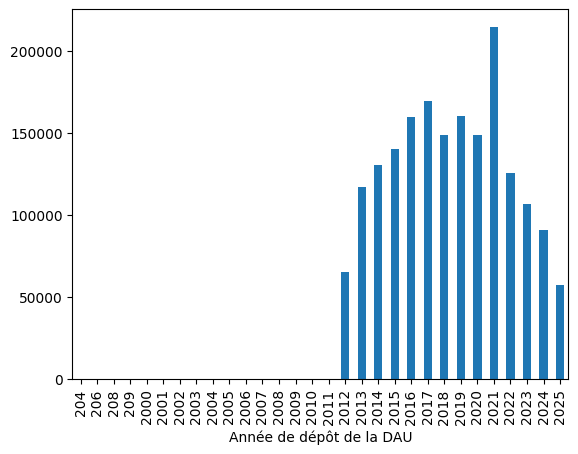

In [66]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot.bar()


On peut supprimer tout ce qui vient avant 2012, 2012 compris ainsi que l'année 2025 qui est en cours 

In [67]:
ligns_few_values = (df["Année de dépôt de la DAU"]<=2012) | (df["Année de dépôt de la DAU"] == 2025)
df = df.drop(df.index[ligns_few_values])

<Axes: xlabel='Année de dépôt de la DAU'>

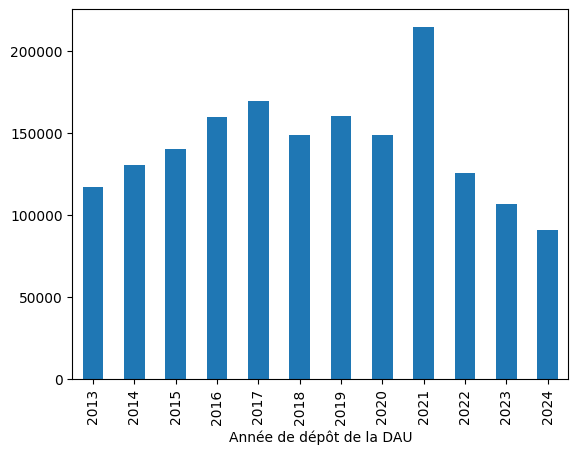

In [68]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot.bar()


### Cleaning Departments 

In [74]:
df["Code du département du lieu des travaux - Code de la zone"].nunique()

101

We see that there are 102 departments instead of 101, as for the previous notebook, we imagine that the problem is that one department is coded two times, one time with one digit (2, Aisne) and the other with two (02, Aisne). We harmonize the gap

In [72]:
df.loc[df["Code du département du lieu des travaux - Code de la zone"].str.len()==1,"Code du département du lieu des travaux - Code de la zone"] 

8192     1
8193     1
8194     1
8195     1
8196     1
        ..
99893    9
99894    9
99895    9
99896    9
99897    9
Name: Code du département du lieu des travaux - Code de la zone, Length: 85513, dtype: string

In [73]:
df["Code du département du lieu des travaux - Code de la zone"]=df["Code du département du lieu des travaux - Code de la zone"].str.zfill(2)

### Isolating overseas departments (DOM)

In [75]:
df_dom = df.loc[df["Code du département du lieu des travaux - Code de la zone"].str.startswith("97")] 
df = df.drop(df_dom.index)

<Axes: xlabel='Année de dépôt de la DAU'>

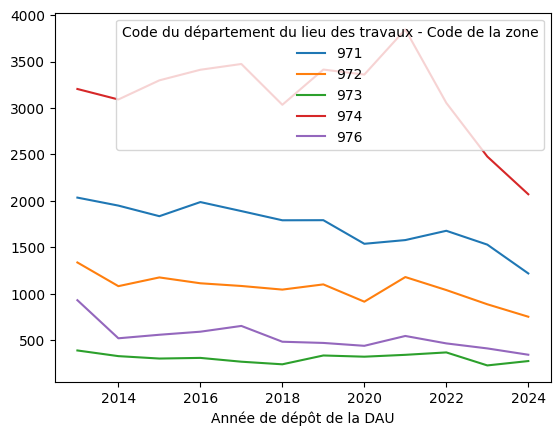

In [76]:
df_dom.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot()


###  TODO Replacing qualitative numeric value by its name 

In [77]:
destinations = [
    "habitation",
    "hébergement hôtelier",
    "bureaux",
    "commerce",
    "artisanat",
    "industrie",
    "agriculture",
    "entrepôt",
    "service public ou d'intérêt collectif"
]

dict_destination_principale = {key: value for key, value in zip(range(1, 10), destinations)}


In [78]:
df.loc[~df["Destination principale"].isin(range(1, 10)),"Destination principale"]

1          1
2          1
3          1
4          1
5          1
          ..
1751520    1
1751521    1
1751522    1
1751523    1
1751524    1
Name: Destination principale, Length: 1632746, dtype: string

In [79]:

df["Destination principale"] = pd.to_numeric(df["Destination principale"],errors="coerce")
df["Destination principale"] = df["Destination principale"].apply(lambda x : dict_destination_principale[x])


## First descriptive statistics 

### TODO : Main usage of the building before and after 

In [80]:
df["Destination principale"].value_counts()

Destination principale
habitation    1632746
Name: count, dtype: int64

In [81]:
df["Type principal des locaux d'origine transformés"].value_counts()

KeyError: "Type principal des locaux d'origine transformés"

### Construction Activity Time Series

<Axes: xlabel='Année de dépôt de la DAU'>

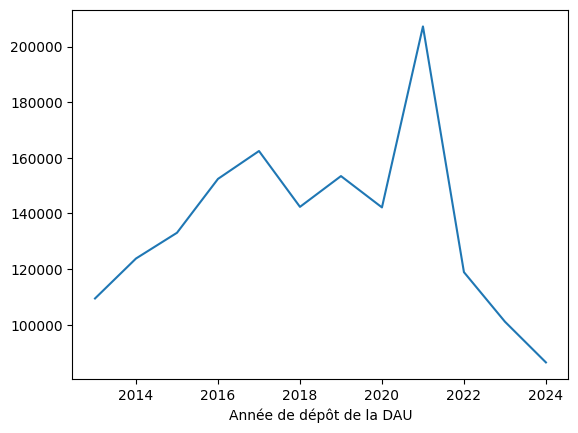

In [82]:
df["Année de dépôt de la DAU"].value_counts().sort_index().plot()


In [83]:
df["Date"] = df["Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)"]


In [84]:
df[df["Date"].dt.year<=2012][col_dates_travaux+["Année de dépôt de la DAU"]]


Date réelle d’autorisation (PC) ou de non-opposition (DP) initiale  \
34596                                           2013-02-15                   
71168                                           2013-02-27                   
132573                                          2013-06-24                   
148990                                          2013-04-23                   
325233                                          2013-01-22                   
467497                                          2013-06-19                   
508507                                          2013-02-28                   
697105                                          2020-07-29                   
707814                                          2020-03-06                   
722300                                          2013-01-18                   
1087993                                         2013-07-11                   
1176253                                         2013-05-29                   
1576574                                         2013-05-21                   

        Date réelle d’ouverture de chantier  \
34596                                   NaT   
71168                                   NaT   
132573                           2014-12-18   
148990                           2013-05-01   
325233                                  NaT   
467497                           2014-06-05   
508507                           2013-03-07   
697105                           2020-08-01   
707814                           2020-07-01   
722300                                  NaT   
1087993                                 NaT   
1176253                          2014-01-31   
1576574                          2014-01-15   

        Date réelle d’achèvement des travaux  \
34596                                    NaT   
71168                                    NaT   
132573                            2016-08-31   
148990                            2014-10-03   
325233                                   NaT   
467497                            2016-04-08   
508507                            2016-05-10   
697105                                   NaT   
707814                            2021-01-01   
722300                                   NaT   
1087993                                  NaT   
1176253                                  NaT   
1576574                           2016-03-14   

        Date (mois) de prise en compte (DPC) du premier évènement reçu dans Sitadel (dépôt de la demande ou autorisation)  \
34596                                           2012-12-01                                                                  
71168                                           2012-12-01                                                                  
132573                                          2012-12-01                                                                  
148990                                          2012-12-01                                                                  
325233                                          2012-12-01                                                                  
467497                                          2012-12-01                                                                  
508507                                          2012-12-01                                                                  
697105                                          2010-03-01                                                                  
707814                                          2010-06-01                                                                  
722300                                          2012-12-01                                                                  
1087993                                         2012-12-01                                                                  
1176253                                         2012-09-01                         

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.9757e+04, 4.9429e+04, 4.3794e+04,
        5.1612e+04, 4.9325e+04, 4.2587e+04, 5.4890e+04, 5.5377e+04,
        4.8610e+04, 6.2529e+04, 7.0751e+04, 5.4352e+04, 6.8196e+04,
        5.6363e+04, 4.7811e+04, 6.2370e+04, 6.5906e+04, 5.1853e+04,
        5.2422e+04, 5.8669e+04, 5.6714e+04, 7.5173e+04, 7.5428e+04,
        6.6314e+04, 5.6667e+04, 5.1869e+04, 3.6465e+04, 4.1821e+04,
        3.7311e+04, 3.0440e+04, 3.5580e+04, 2.0120e+03, 3.4200e+02]),
 array([14669.   , 14811.325, 14953.65 , 15095.975, 15238.3  , 15380.625,
        15522.95 , 15665.275, 15807.6  , 15949.925, 16092.25 , 16234.575,
        16376.9  , 16519.225, 16661.55 , 16803.875, 16946.2  , 17088.525,
        17230.85 , 17373.175, 17515.5  , 17657.825, 17800.15 , 17942.475,
        18084.8  , 18227.125, 18369.45 , 18511.775, 18654.1  , 18796.425,
        18938.75 , 19081.075, 19223.4  , 19365.725, 19508.05 , 19650.375,
        19

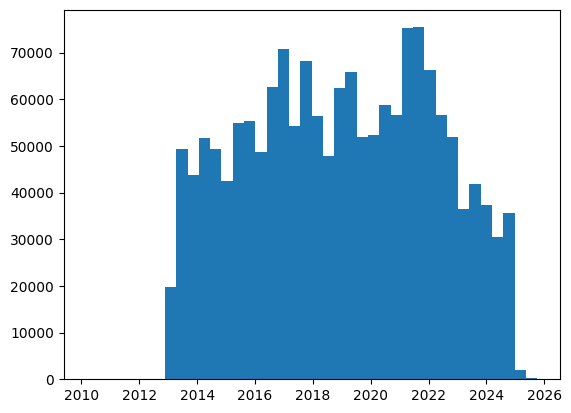

In [85]:
plt.hist(df["Date"], bins=40)    


### Question : In which departments did we build the most ? 

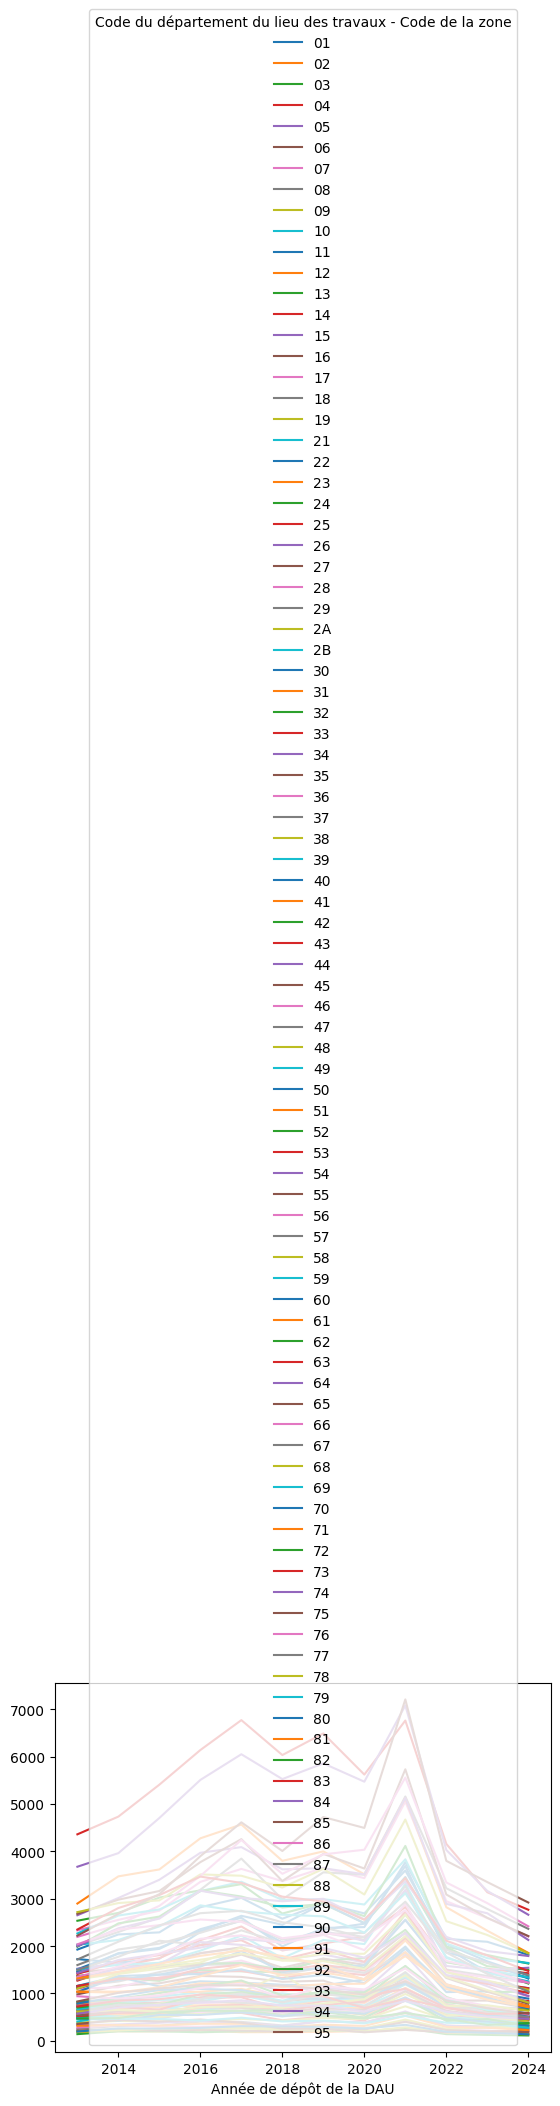

In [86]:
activity_per_department = df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot()


array([[<Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>],
       [<Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année de dépôt de la DAU'>,
        <Axes: xlabel='Année d

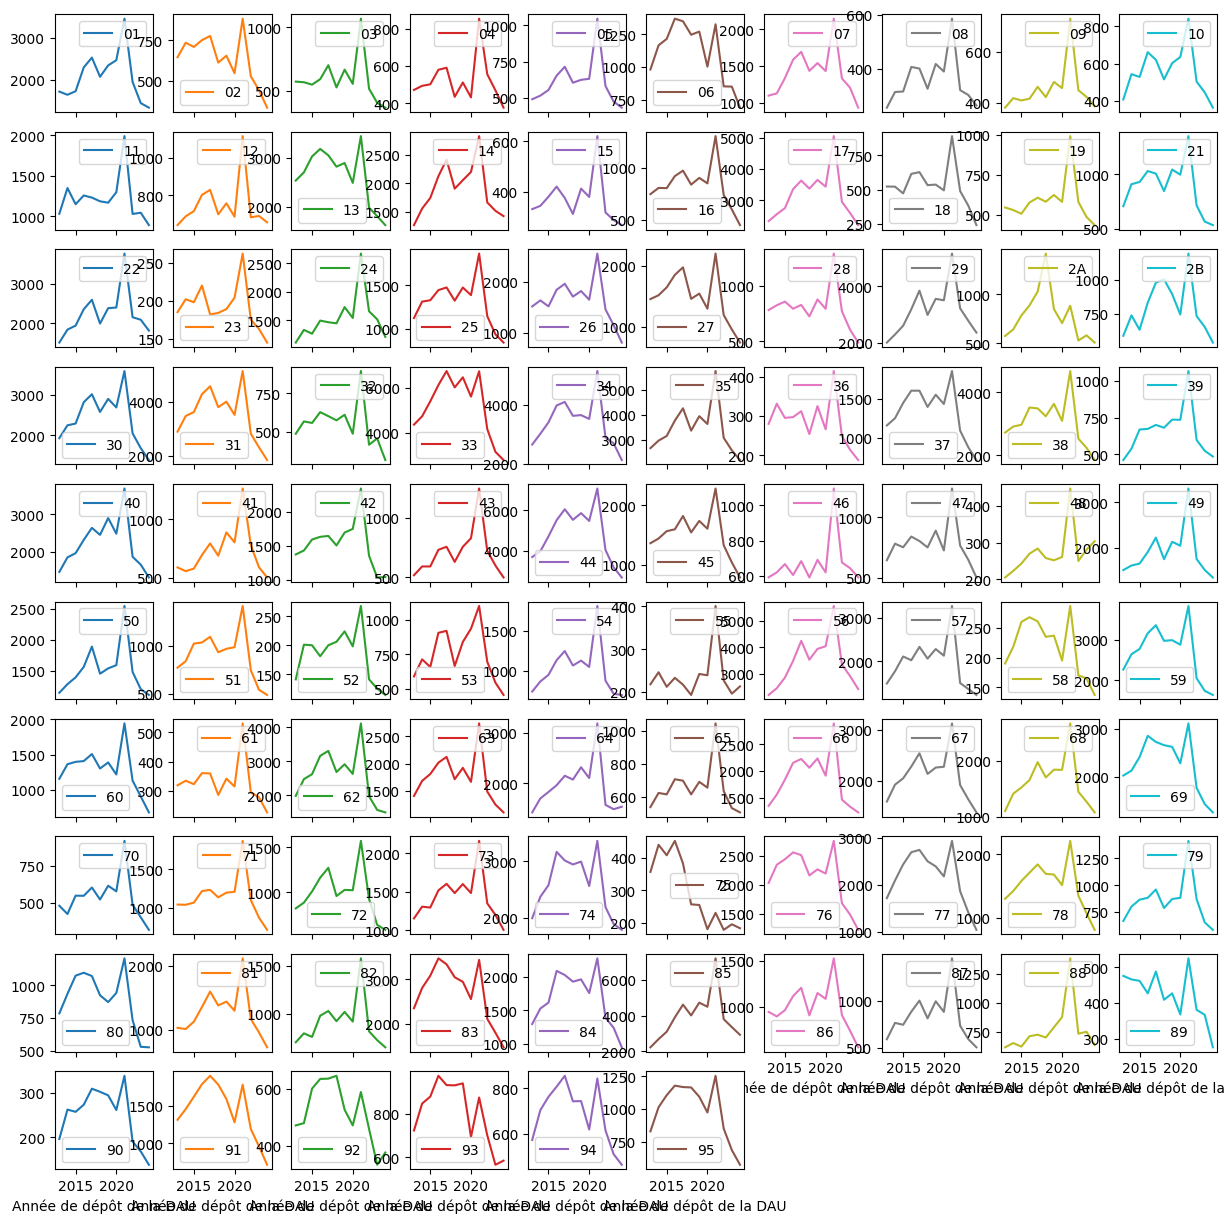

In [87]:
df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(0).sort_index().plot(
    subplots=True,
    layout=(10,10),
    figsize=(15,15),
    legend=True 
)


In [88]:
activity_per_department = df.groupby(["Code du département du lieu des travaux - Code de la zone", "Année de dépôt de la DAU"]).size().unstack(1)
activity_per_department.head(50)

Année de dépôt de la DAU                            2013  2014  2015  2016  \
Code du département du lieu des travaux - Code ...                           
01                                                  1725  1650  1734  2300   
02                                                   644   734   708   750   
03                                                   572   567   548   591   
04                                                   471   493   501   579   
05                                                   490   515   554   653   
06                                                   980  1165  1214  1369   
07                                                  1101  1131  1338  1587   
08                                                   255   313   315   406   
09                                                   382   419   410   417   
10                                                   408   544   529   662   
11                                                  1030  1348  1148  1256   
12                                                   640   687   715   802   
13                                                  2534  2700  3023  3175   
14                                                  1270  1559  1744  2124   
15                                                   332   345   381   421   
16                                                   745   805   803   919   
17                                                  2331  2553  2747  3354   
18                                                   523   522   473   615   
19                                                   545   529   506   576   
21                                                   708   908   929  1028   
22                                                  1510  1839  1940  2356   
23                                                   185   202   198   220   
24                                                  1110  1332  1265  1495   
25                                                  1123  1312  1328  1445   
26                                                  1521  1640  1522  1848   
27                                                  1453  1516  1645  1850   
28                                                   781   824   857   793   
29                                                  2011  2297  2606  3188   
2A                                                   575   642   784   887   
2B                                                   587   737   631   830   
30                                                  1926  2245  2289  2819   
31                                                  2897  3471  3617  4274   
32                                                   489   569   559   629   
33                                                  4358  4732  5406  6137   
34                                                  2651  3014  3399  3968   
35                                                  2681  2979  3162  3771   
36                                                   280   331   295   297   
37                                                  1159  1252  1450  1608   
38                                                  2716  2908  2964  3512   
39                                                   462   539   670   674   
40                                                  1462  1850  1962  2317   
41                                                   590   558   580   696   
42                                                  1369  1428  1589  1629   
43                                                   519   592   592   731   
44                                                  3674  3961  4703  5506   
45                                                  1361  1440  1564  1595   
46                                                   592   620   667   605   
47                                                   644   781   751   840   
48                                                   205   223   243   270   
49                    

It's not very convenient to read and analyze, let's try making it clearer, however we will this time try to answer it in a more direct fashion i.e. clustering groups of datas

#### Clustering groups of departments

In [135]:
X = activity_per_department.fillna(0)
X = (X - X.mean(axis=1).values[:, None]) / X.std(axis=1).values[:, None]


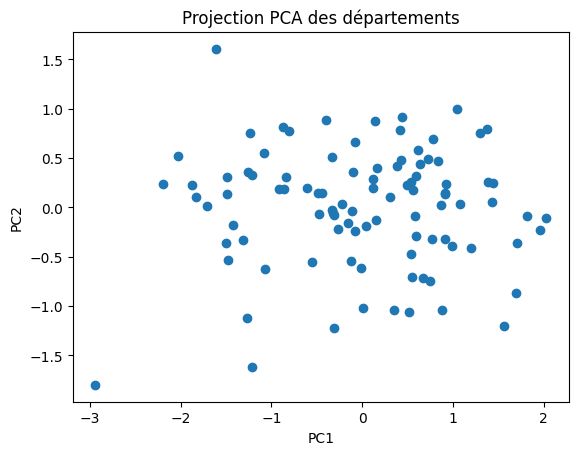

In [139]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.values)

plt.scatter(X_pca[:,0], X_pca[:,1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Projection PCA des départements")
plt.show()


In [148]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
labels = kmeans.fit_predict(X.values)

activity_per_department["cluster"] = labels


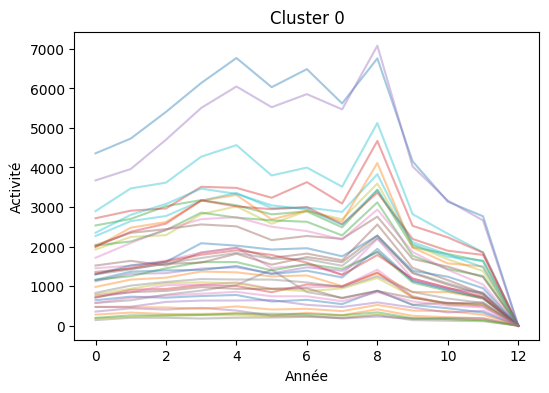

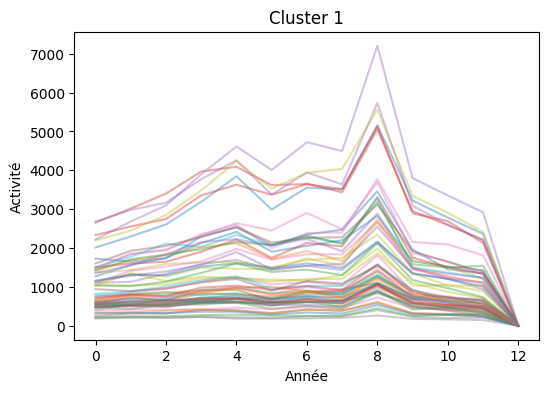

In [149]:
import matplotlib.pyplot as plt

for k in sorted(activity_per_department["cluster"].unique()):
    plt.figure(figsize=(6,4))
    for _, row in activity_per_department[
        activity_per_department["cluster"] == k
    ].drop(columns="cluster").iterrows():
        plt.plot(row.values, alpha=0.4)
    plt.title(f"Cluster {k}")
    plt.xlabel("Année")
    plt.ylabel("Activité")
    plt.show()


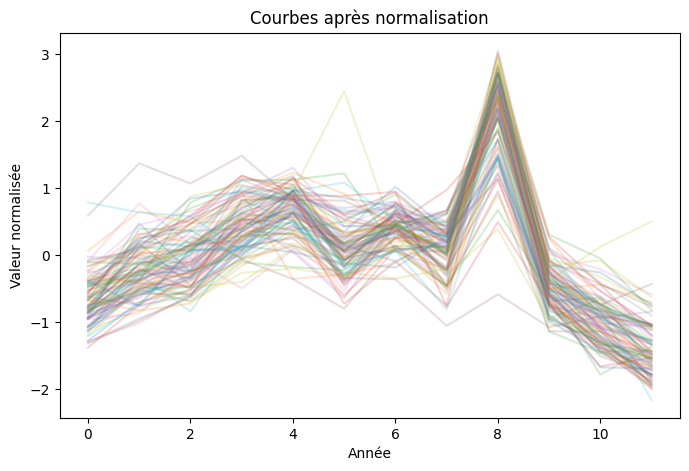

In [152]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for _, row in X.iterrows():
    plt.plot(row.values, alpha=0.2)
plt.title("Courbes après normalisation")
plt.xlabel("Année")
plt.ylabel("Valeur normalisée")
plt.show()


In [155]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_norm.values)

X_norm["cluster"] = labels


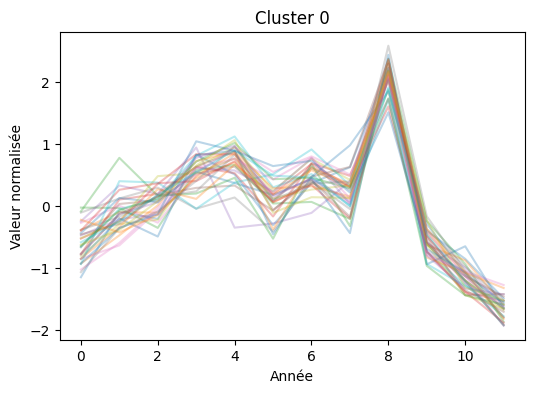

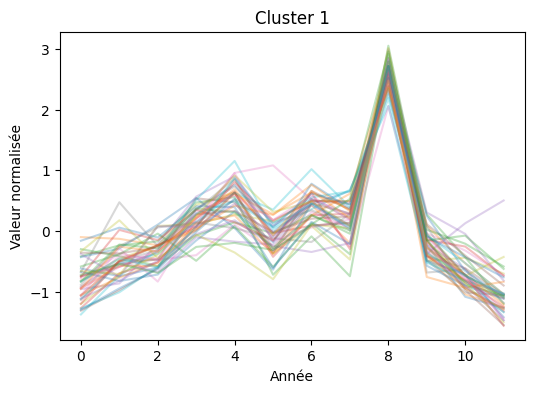

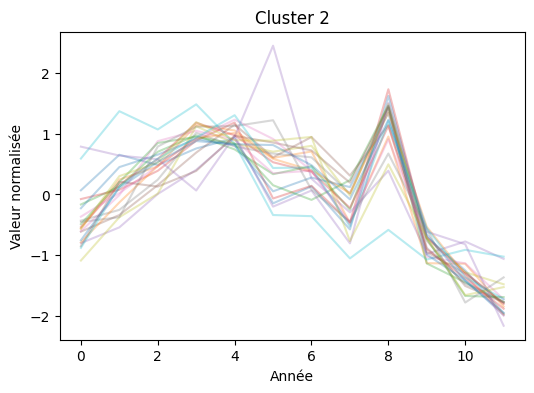

In [156]:
import matplotlib.pyplot as plt
X_norm = X
for k in sorted(X_norm["cluster"].unique()):
    plt.figure(figsize=(6,4))
    for _, row in X_norm[X_norm["cluster"] == k].drop(columns="cluster").iterrows():
        plt.plot(row.values, alpha=0.3)
    plt.title(f"Cluster {k}")
    plt.xlabel("Année")
    plt.ylabel("Valeur normalisée")
    plt.show()


Let's first determine for a given year, in which departments did we build the most 
#### Q1 : For the year 2024, in which department did we build the most ? 

In [131]:
construction_activity2024 = activity_per_department[2024].sort_values().reset_index()

In [128]:
construction_activity2024.nunique()

Code du département du lieu des travaux - Code de la zone    96
2024                                                         96
dtype: int64

#### -> Q1 : Let's represent departments on a map 

In [92]:
deps = gpd.read_file("https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements.geojson")

In [93]:
deps.index = deps.index.astype(str).str.zfill(2)
deps.head(50)


code                      nom  \
00   01                      Ain   
01   02                    Aisne   
02   03                   Allier   
03   04  Alpes-de-Haute-Provence   
04   05             Hautes-Alpes   
05   06          Alpes-Maritimes   
06   2A             Corse-du-Sud   
07   2B              Haute-Corse   
08   07                  Ardèche   
09   08                 Ardennes   
10   09                   Ariège   
11   10                     Aube   
12   11                     Aude   
13   12                  Aveyron   
14   13         Bouches-du-Rhône   
15   14                 Calvados   
16   15                   Cantal   
17   16                 Charente   
18   17        Charente-Maritime   
19   18                     Cher   
20   19                  Corrèze   
21   21                Côte-d'Or   
22   22            Côtes-d'Armor   
23   23                   Creuse   
24   24                 Dordogne   
25   25                    Doubs   
26   26                    Drôme   
27   27                     Eure   
28   28             Eure-et-Loir   
29   29                Finistère   
30   30                     Gard   
31   31            Haute-Garonne   
32   32                     Gers   
33   33                  Gironde   
34   34                  Hérault   
35   35          Ille-et-Vilaine   
36   36                    Indre   
37   37           Indre-et-Loire   
38   38                    Isère   
39   39                     Jura   
40   40                   Landes   
41   41             Loir-et-Cher   
42   42                    Loire   
43   43              Haute-Loire   
44   44         Loire-Atlantique   
45   45                   Loiret   
46   46                      Lot   
47   47           Lot-et-Garonne   
48   48                   Lozère   
49   49           Maine-et-Loire   

                                             geometry  
00  POLYGON ((4.78021 46.17668, 4.78024 46.18905, ...  
01  POLYGON ((3.17296 50.01131, 3.17382 50.01186, ...  
02  POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3...  
03  POLYGON ((5.67604 44.19143, 5.67817 44.19051, ...  
04  POLYGON ((6.26057 45.12685, 6.26417 45.12641, ...  
05  MULTIPOLYGON (((7.06711 43.51365, 7.06665 43.5...  
06  MULTIPOLYGON (((8.5864 41.87389, 8.58667 41.87...  
07  MULTIPOLYGON (((9.40875 43.02232, 9.40662 43.0...  
08  POLYGON ((4.48313 45.23645, 4.4879 45.23218, 4...  
09  POLYGON ((4.23316 49.95775, 4.2369 49.95858, 4...  
10  POLYGON ((1.68842 43.27355, 1.69139 43.27173, ...  
11  POLYGON ((3.41479 48.39027, 3.41555 48.39373, ...  
12  POLYGON ((1.68842 43.27355, 1.69029 43.27437, ...  
13  POLYGON ((2.20748 44.61553, 2.20885 44.61631, ...  
14  MULTIPOLYGON (((5.3967 43.173, 5.39314 43.1730...  
15  MULTIPOLYGON (((-0.43055 48.86309, -0.43295 48...  
16  POLYGON ((2.50841 45.4785, 2.51056 45.47944, 2...  
17  POLYGON ((-0.10294 45.96966, -0.09758 45.97113...  
18  MULTIPOLYGON (((-1.11427 45.95173, -1.1163 45....  
19  POLYGON ((2.23921 47.62098, 2.24348 47.62084, ...  
20  POLYGON ((1.89873 45.69828, 1.89931 45.69828, ...  
21  MULTIPOLYGON (((4.11597 47.12334, 4.11 47.1261...  
22  MULTIPOLYGON (((-3.47716 48.88127, -3.47863 48...  
23  POLYGON ((2.16779 46.42407, 2.17254 46.42228, ...  
24  POLYGON ((0.62974 45.71457, 0.63094 45.71328, ...  
25  POLYGON ((6.80701 47.5628, 6.80981 47.55751, 6...  
26  POLYGON ((4.80049 45.29836, 4.80552 45.29935, ...  
27  POLYGON ((0.29722 49.42986, 0.3078 49.43063, 0...  
28  POLYGON ((0.81482 48.67017, 0.81727 48.67262, ...  
29  MULTIPOLYGON (((-4.0004 47.72283, -4.00391 47....  
30  POLYGON ((3.37365 44.17076, 3.38309 44.17041, ...  
31  POLYGON ((0.95398 43.78737, 0.956 43.78933, 0....  
32  POLYGON ((0.07605 43.98314, 0.07628 43.98202, ...  
33  MULTIPOLYGON (((-1.23902 44.59278, -1.23583 44...  
34  MULTIPOLYGON (((3.50066 43.2629, 3.50223 43.26...  
35  MULTIPOLYGON (((-2.15926 48.6372, -2.16138 48....  
36  POLYGON ((1.32667 47.18623, 1.33849 47.19554, ...  
37  POLYGON ((0.61443 47.69421, 0.6152

In [132]:
construction_activity2024 = construction_activity2024.merge(
    deps,
    left_on="Code du département du lieu des travaux - Code de la zone",
    right_on="code",
    how="left"
)

construction_activity2024.head(50)


Code du département du lieu des travaux - Code de la zone  2024 code  \
0                                                  52          114   52   
1                                                  58          137   58   
2                                                  90          138   90   
3                                                  23          145   23   
4                                                  75          184   75   
5                                                  36          188   36   
6                                                  55          213   55   
7                                                  61          225   61   
8                                                  18          242   18   
9                                                  08          263   08   
10                                                 15          269   15   
11                                                 89          276   89   
12                                                 48          304   48   
13                                                 70          316   70   
14                                                 32          319   32   
15                                                 02          332   02   
16                                                 10          364   10   
17                                                 03          367   03   
18                                                 04          376   04   
19                                                 92          377   92   
20                                                 09          387   09   
21                                                 05          432   05   
22                                                 19          435   19   
23                                                 16          446   16   
24                                                 53          456   53   
25                                                 94          462   94   
26                                                 39          486   39   
27                                                 28          489   28   
28                                                 51          490   51   
29                                                 43          500   43   
30                                                 47          501   47   
31                                                 87          503   87   
32                                                 41          504   41   
33                                                 65          505   65   
34                                                 2A          508   2A   
35                                                 80          527   80   
36                                                 21          536   21   
37                                                 2B          537   2B   
38                                                 86          552   86   
39                                                 95          575   95   
40                                                 72          580   72   
41                                                 79          583   79   
42                                                 93          585   93   
43                                                 46          592   46   
44                                                 88          635   88   
45                                                 82          649   82   
46                                                 12          655   12   
47                                                 60          683   60   
48                                                 06          688   06   
49                                                 54          691   54   

                        nom                                           geometry  
0               Haute-Marne  POLYGON ((4.67018 48.53189, 4.67374 48.53396, ...  
1              

In [133]:
construction_activity2024 = gpd.GeoDataFrame(
    construction_activity2024,
    geometry="geometry",
    crs=deps.crs
)

<Axes: >

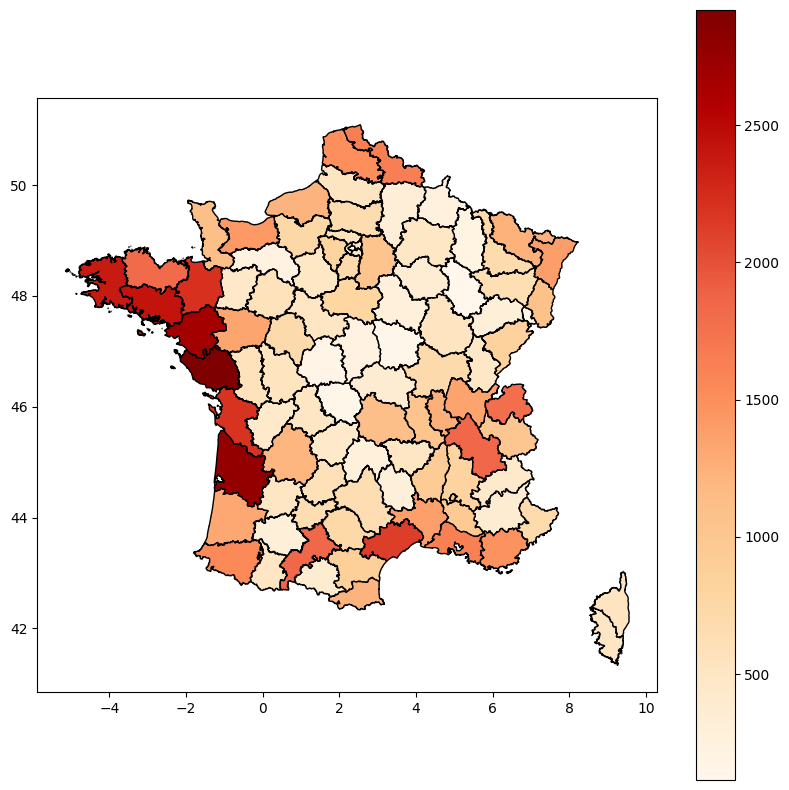

In [134]:
construction_activity2024.plot(
    column=2024,
    cmap="OrRd",
    legend=True,
    figsize=(10, 10),
    edgecolor="black"
) 

#### TODO -> Q1 What's happening in Bordeaux ? 

In [98]:
df.loc[
    df["Code du département du lieu des travaux - Code de la zone"] == "33",
    "Destination principale"
].value_counts()


Destination principale
habitation    62355
Name: count, dtype: int64

#### Q2 : In which department was growth the strongest ? 

In [116]:
growth_per_department = activity_per_department.pct_change(axis=1)



In [100]:
growth_per_department = growth_per_department.mean(axis=1).reset_index()


In [101]:
growth_per_department = growth_per_department.merge(
    deps,
    left_on="Code du département du lieu des travaux - Code de la zone",
    right_on="code",
    how="left"
)

In [102]:
growth_per_department = growth_per_department.rename(columns={0:"Avg_growth_rate"})

In [103]:
growth_per_department = gpd.GeoDataFrame(
    growth_per_department,
    geometry="geometry",
    crs=deps.crs
)

In [104]:
growth_per_department.columns

Index(['Code du département du lieu des travaux - Code de la zone',
       'Avg_growth_rate', 'code', 'nom', 'geometry'],
      dtype='object')

<Axes: >

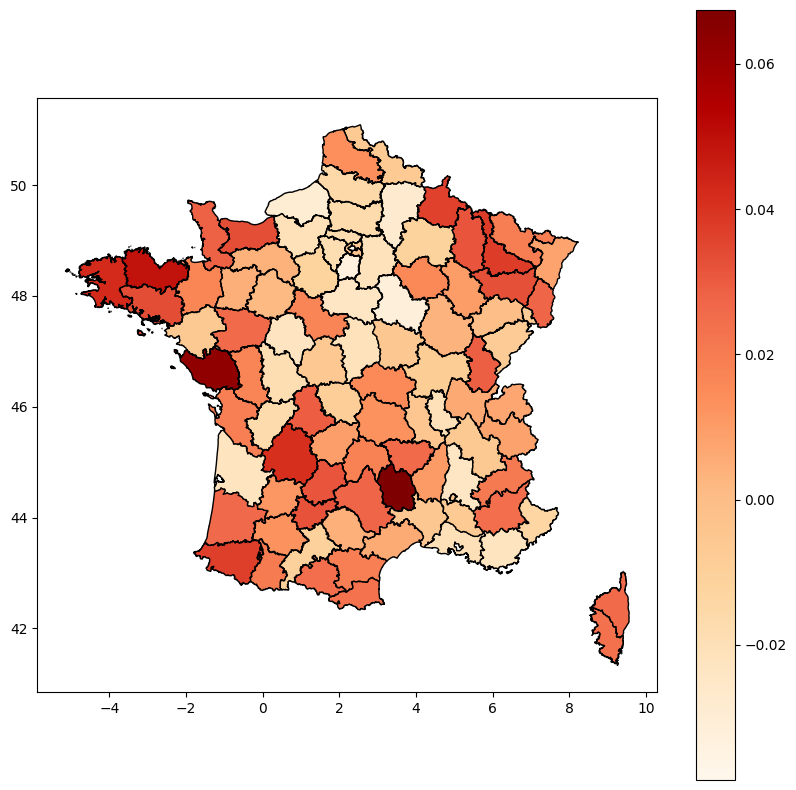

In [105]:
growth_per_department.plot(
    column="Avg_growth_rate",
    cmap="OrRd",
    legend=True,
    figsize=(10, 10),
    edgecolor="black"
) 

In [106]:
growth_per_department.sort_values(by="Avg_growth_rate", ascending=False).head(10)

Code du département du lieu des travaux - Code de la zone  Avg_growth_rate  \
48                                                 48                0.067429   
85                                                 85                0.062510   
20                                                 22                0.049101   
27                                                 29                0.042540   
22                                                 24                0.040943   
54                                                 54                0.037856   
64                                                 64                0.037134   
7                                                  08                0.036532   
56                                                 56                0.033810   
13                                                 14                0.033064   

   code                   nom  \
48   48                Lozère   
85   85                Vendée   
20   22         Côtes-d'Armor   
27   29             Finistère   
22   24              Dordogne   
54   54    Meurthe-et-Moselle   
64   64  Pyrénées-Atlantiques   
7    08              Ardennes   
56   56              Morbihan   
13   14              Calvados   

                                             geometry  
48  POLYGON ((3.36134 44.97141, 3.36229 44.97131, ...  
85  MULTIPOLYGON (((-2.30479 46.70942, -2.30209 46...  
20  MULTIPOLYGON (((-3.47716 48.88127, -3.47863 48...  
27  MULTIPOLYGON (((-4.0004 47.72283, -4.00391 47....  
22  POLYGON ((0.62974 45.71457, 0.63094 45.71328, ...  
54  MULTIPOLYGON (((5.45245 49.41235, 5.46144 49.4...  
64  POLYGON ((-0.24284 43.58498, -0.24233 43.58342...  
7   POLYGON ((4.23316 49.95775, 4.2369 49.95858, 4...  
56  MULTIPOLYGON (((-3.01322 47.41074, -3.01772 47...  
13  MULTIPOLYGON (((-0.43055 48.86309, -0.43295 48...

In [126]:
activity_per_department.iloc[80:88]


Année de dépôt de la DAU                            2013  2014  2015  2016  \
Code du département du lieu des travaux - Code ...                           
80                                                   786   935  1074  1096   
81                                                  1035  1017  1131  1360   
82                                                   702   795   758   979   
83                                                  2349  2803  3077  3466   
84                                                  1295  1525  1614  2085   
85                                                  2220  2680  3095  3897   
86                                                   941   891   960  1114   
87                                                   589   763   743   882   

Année de dépôt de la DAU                            2017  2018  2019  2020  \
Code du département du lieu des travaux - Code ...                           
80                                                  1071   924   872   942   
81                                                  1600  1384  1444  1302   
82                                                  1029   922  1019   918   
83                                                  3332  3043  2940  2554   
84                                                  2024  1925  1959  1755   
85                                                  4611  4006  4723  4493   
86                                                  1206   903  1148  1084   
87                                                  1000   811   993   880   

Année de dépôt de la DAU                            2021  2022  2023  2024  
Code du département du lieu des travaux - Code ...                          
80                                                  1206   734   531   527  
81                                                  2118  1173   965   732  
82                                                  1579   816   724   649  
83                                                  3432  2112  1801  1474  
84                                                  2272  1389  1239   948  
85                                                  7205  3798  3350  2919  
86                                                  1529   905   734   552  
87                                                  1450   732   590   503

### Density of construction

In [ ]:
df.loc[:,col_relevant].head()

Code de la région du lieu des travaux - Code de la zone  \
1                                                 82        
2                                                 82        
3                                                 82        
4                                                 82        
5                                                 82        

  Code de la région du lieu des travaux - Libellé de la zone  \
1                                        Rhône-Alpes           
2                                        Rhône-Alpes           
3                                        Rhône-Alpes           
4                                        Rhône-Alpes           
5                                        Rhône-Alpes           

  Code du département du lieu des travaux - Code de la zone  \
1                                                 01          
2                                                 01          
3                                                 01          
4                                                 01          
5                                                 01          

  Code du département du lieu des travaux - Libellé de la zone  \
1                                                Ain             
2                                                Ain             
3                                                Ain             
4                                                Ain             
5                                                Ain             

  Code de la commune du lieu des travaux Etat d'avancement du projet  \
1                                  01001                           5   
2                                  01001                           2   
3                                  01001                           5   
4                                  01001                           2   
5                                  01001                           2   

  Code d'activité principale de l'établissement d'un demandeur avéré en tant que personne morale  \
1                                             01.50Z                                               
2                                             01.61Z                                               
3                                               <NA>                                               
4                                               <NA>                                               
5                                             61.10Z                                               

  Catégorie juridique d'un demandeur avéré en tant que personne morale  \
1                                               6533                     
2                                               6316                     
3                                               <NA>                     
4                                               <NA>                     
5                                               5599                     

  Dénomination d'un demandeur avéré en tant que personne morale  \
1  GROUPEMENT AGRICOLE D'EXPLOITATION EN COMMUN R...              
2                    CUMA DE L'ABERGEMENT CLEMENCIAT              
3                                               <NA>              
4                                               <NA>              
5                                     FRANCE TELECOM              

  Numéro SIREN d'un demandeur avéré en tant que personne morale  ...  \
1                                          434449088             ...   
2                                          779289941             ...   
3                                               <NA>             ...   
4                                               <NA>             ...   
5                                          380129866             ...   

  Nature du projet déclarée par le demandeur Nature de projet détaillée  \
1                                          1                          1   
2        

In [150]:
df['Geometry'] = df.apply(
    lambda x: Point(x["longitude"], x["latitude"]) 
    if x["longitude"] and x["latitude"] 
    else None,
    axis = 1
)
gdf = gpd.GeoDataFrame(
    df,              # les données
    geometry="Geometry",     # La colonne de géométrie
    crs='EPSG:4326'       # Système de coordonnées WGS84
)



In [198]:
gdf = gdf.to_crs(epsg=2154)  # example: France


In [ ]:
gdf_clean = gdf[
    (gdf.geometry.x.between(200_000, 1_200_000)) &
    (gdf.geometry.y.between(6_000_000, 7_200_000))
]


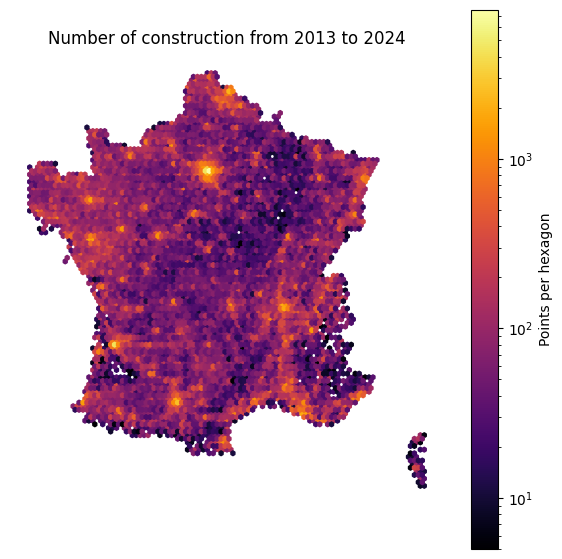

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7))

graph_heatmap_nonresid = ax.hexbin(
    gdf_clean.geometry.x,
    gdf_clean.geometry.y,
    gridsize=100,
    cmap="inferno",
    mincnt=5,
    bins="log" 
)

ax.set_aspect("equal")
ax.set_axis_off()

plt.colorbar(hb, label="Points per hexagon")
plt.title("Number of construction from 2013 to 2024")
plt.show()


We want to zoom on the Paris region

/tmp/ipykernel_168936/326923706.py:21: UserWarning: Adding colorbar to a different Figure <Figure size 500x500 with 8 Axes> than <Figure size 700x700 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(hb, label="Points per hexagon")


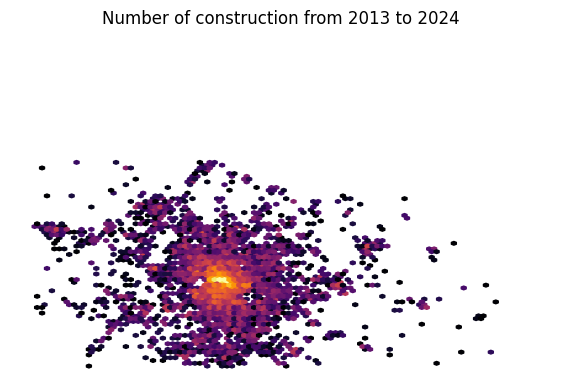

In [290]:
gdf_idf = gdf[gdf["Code de la région du lieu des travaux - Code de la zone"] == "11"]
gdf_idf = gdf_idf[
    gdf_idf.geometry.x.between(600_000, 750_000) &
    gdf_idf.geometry.y.between(6_840_000, 6_930_000)
]

fig, ax = plt.subplots(figsize=(7, 7))
graph_heatmap_nonresid_idf = ax.hexbin(
    gdf_idf.geometry.x,
    gdf_idf.geometry.y,
    gridsize=100,
    cmap="inferno",
    mincnt=5,
    bins="log" 
)

ax.set_aspect("equal")
ax.set_axis_off()


plt.colorbar(hb, label="Points per hexagon")
plt.title("Number of construction from 2013 to 2024")
plt.show()

Pour mieux analyser la carte, on peut passer sur Folium pour avoir un fond de carte interactif

In [314]:
gdf_idf = gdf.loc[gdf["Code de la région du lieu des travaux - Code de la zone"] == "11"]


In [323]:
gdf_wgs.sample(50)


Unnamed: 0 Code de la région du lieu des travaux - Code de la zone  \
750384      750384                                                 11        
648036      648036                                                 11        
657439      657439                                                 11        
629929      629929                                                 11        
644714      644714                                                 11        
742672      742672                                                 11        
628749      628749                                                 11        
750282      750282                                                 11        
758183      758183                                                 11        
767398      767398                                                 11        
758937      758937                                                 11        
657626      657626                                                 11        
656144      656144                                                 11        
765215      765215                                                 11        
628221      628221                                                 11        
657696      657696                                                 11        
744618      744618                                                 11        
752879      752879                                                 11        
647034      647034                                                 11        
627553      627553                                                 11        
742683      742683                                                 11        
766187      766187                                                 11        
630375      630375                                                 11        
632363      632363                                                 11        
648892      648892                                                 11        
746611      746611                                                 11        
767261      767261                                                 11        
645770      645770                                                 11        
742820      742820                                                 11        
650991      650991                                                 11        
624953      624953                                                 11        
746714      746714                                                 11        
647726      647726                                                 11        
755287      755287                                                 11        
760417      760417                                                 11        
756791      756791                                                 11        
768296      768296                                                 11        
623636      623636                                                 11        
757733      757733                                                 11        
649958      649958                                                 11        
627456      627456                                                 11        
762517      762517                                                 11        
752971      752971                                                 11        
759035      759035                                                 11        
627397      627397                                                 11        
655837      655837                                                 11        
746489      746489                                                 11        
743265      743265                                                 11        
753421      753421                                                 11        
630072      630072                                                 11        

       Code de la région du l

In [313]:
import folium
from folium.plugins import HeatMap

# passer en WGS84 (obligatoire pour folium)
gdf_wgs = gdf_idf.to_crs(epsg=4326)
gdf_wgs = gdf_wgs[
    gdf_wgs.geometry.notna() &
    ~gdf_wgs.geometry.is_empty &
    gdf_wgs.geometry.x.notna() &
    gdf_wgs.geometry.y.notna()
]

# centrer sur l'IDF
center = [
    gdf_wgs.geometry.y.mean(),
    gdf_wgs.geometry.x.mean()
]

m = folium.Map(
    location=center,
    zoom_start=9,
    tiles="CartoDB positron"
)

HeatMap(
    data=list(zip(
        gdf_wgs.geometry.y,
        gdf_wgs.geometry.x
    )),
    radius=10,
    blur=15
).add_to(m)

m


In [324]:
print(len(gdf))
print(len(gdf_idf))
print(gdf["Code de la région du lieu des travaux - Code de la zone"].unique())


727905
50937
<StringArray>
['82', '22', '83', '93', '21', '73', '91', '25', '54', '24', '74', '26', '53',
 '72', '43', '23', '94', '52', '41', '31', '42', '11']
Length: 22, dtype: string


In [326]:
gdf_wgs.total_bounds


array([-63.086145, -22.235635, 166.495668,  51.030773])